In [12]:
import numpy
import py_monte_carlo
import scipy.linalg
from matplotlib import pyplot

In [13]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

In [3]:
edges = [
    ((0, 1), -1.0),
    ((1, 2), 1.0),
    ((2, 3), 1.0),
    ((3, 0), 1.0),
    
    ((1, 7), 1.0),
    
    ((4, 5), -1.0),
    ((5, 6), 1.0),
    ((6, 7), 1.0),
    ((7, 4), 1.0)
]

graph1 = py_monte_carlo.Lattice(edges)

graph2 = py_monte_carlo.Lattice(edges)
graph2.set_enable_semiclassical_update(True)

In [4]:
hs = 10**numpy.linspace(-1, 1, 10)
beta = 4.0

diag_orig = []
diag_loop = []

offdiag_orig = []
offdiag_loop = []

orig_m2 = []
loop_m2 = []

for i, h in enumerate(hs):
    graph1.set_transverse_field(h)
    graph2.set_transverse_field(h)
    
    diag, offd = graph1.average_on_and_off_diagonal(beta, 10000, 8, sampling_wait_buffer=10000)
    diag_orig.append(diag)
    offdiag_orig.append(offd)
    
    diag, offd = graph2.average_on_and_off_diagonal(beta, 10000, 8, sampling_wait_buffer=10000)
    diag_loop.append(diag)
    offdiag_loop.append(offd)
    
    results, _ = graph1.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2, sampling_wait_buffer=10000)
    orig_m2.append(numpy.mean(results, axis=0))
    
    results, _ = graph2.run_quantum_monte_carlo_and_measure_spins(beta, 10000, 8, exponent=2, sampling_wait_buffer=10000)
    loop_m2.append(numpy.mean(results, axis=0))

diag_orig = numpy.asarray(diag_orig)
diag_loop = numpy.asarray(diag_loop)

offdiag_orig = numpy.asarray(offdiag_orig)
offdiag_loop = numpy.asarray(offdiag_loop)

orig_m2 = numpy.asarray(orig_m2)
loop_m2 = numpy.asarray(loop_m2)

In [14]:
nvars = len(set(v for vs, _ in edges for v in vs))
ed_transverse_data = []

for i, h in enumerate(hs):
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    ed_transverse_data.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))

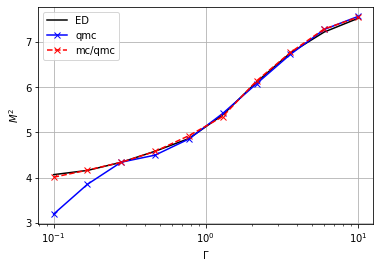

In [19]:
pyplot.plot(hs, ed_transverse_data, label='ED', c='black')
pyplot.plot(hs, orig_m2, 'x-', label='qmc', c='blue')
pyplot.plot(hs, loop_m2, 'x--', label='mc/qmc', c='red')
pyplot.xscale('log')
pyplot.xlabel(r'$\Gamma$')
pyplot.ylabel(r'$M^2$')
pyplot.legend()
pyplot.grid()
pyplot.show()

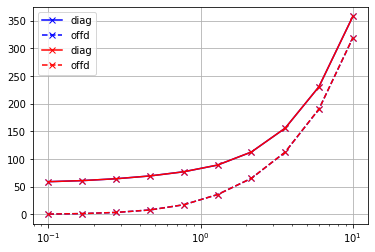

In [6]:
pyplot.plot(hs, diag_orig, 'x-', label='diag', c='blue')
pyplot.plot(hs, offdiag_orig, 'x--', label='offd', c='blue')
pyplot.plot(hs, diag_loop, 'x-', label='diag', c='red')
pyplot.plot(hs, offdiag_loop, 'x--', label='offd', c='red')
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.show()

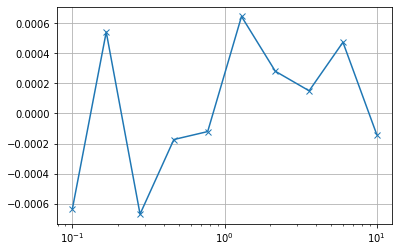

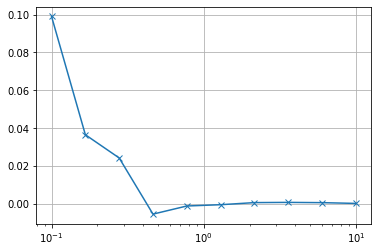

In [7]:
pyplot.plot(hs, (diag_loop-diag_orig)/diag_orig, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()

pyplot.plot(hs, (offdiag_loop-offdiag_orig)/offdiag_orig, 'x-')
pyplot.xscale('log')
pyplot.grid()
pyplot.show()